# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод** 


Таблица содержит 12 столбцов с данными о заемщиках, в столбцах **'days_employed'** и **'total_income'** встречаются пропущенные значения, так же данные столбцы имеют вещественный тип данных. При этом 5 столбцов в таблице имеют целочисленный тип и 5 строковый тип.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [2]:
display(df.isna().sum())#считаем количество пропусков в таблице

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

#### Отрицательные значения в столбце 'days_employed'

In [3]:
display(df['income_type'].unique())#узнаем какой тип занятости есть в таблице
display('Отрицательные значения трудового стажа:',
        df[df['days_employed'] > 0]['income_type'].value_counts())#проверим у кого из таблицы положительный трудовой стаж 
display('Положительные значения трудового стажа:', 
        df[df['days_employed'] < 0]['income_type'].value_counts())#проверим у кого из таблицы отрицательный трудовой стаж 

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

'Отрицательные значения трудового стажа:'

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

'Положительные значения трудового стажа:'

сотрудник          10014
компаньон           4577
госслужащий         1312
в декрете              1
студент                1
предприниматель        1
Name: income_type, dtype: int64

Судя по всему, отрицательные значения в данном столбце наблюдаются во всех категориях кроме: *'пенсионер'* и *'безработный'*. Таким образом можно предположить, что отрицательные значения получаются при автоматическом подсчете стажа. Т.е. берется промежуток в днях от указанной даты начала работы, до даты обращения в банк(настоящей даты) и получают разницу О-X, где O-это настоящая дата, а X-это количество дней трудового стажа.
В случае с *пенсионерами* и *безработными*, дата начала работы не указывается, поэтому у них анамально высокие показатели стажа, программа в данном случае ничего не вычитает, а просто берет точку отсчета от запрограмированной даты и считает дни до момента обращения в банк.

+ **ВАЖНО!!!**
По условиям задания, в дальнейшем исследовании данный столбец нам не понадобится, по этой причине нет смысла предпринимать с ним каких либо действий и заполнять в нем пропуски.

#### Создадим таблицу с пропущенными значениями и посмотрим в каких должностях больше всего пропусков

In [4]:
data = df[df['total_income'].isna()]
#формируем новую таблицу с пропущенными значениями
data['income_type'].value_counts()
#проверяем количество пропущенных значений по типу занятости('income_type')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Судя по полученным данным, можно сделать вывод, что больше всего пропущенных значений у *сотрудников*, далее идут *компаньоны*, *пенсионеры*, *госслужащие* и *предприниматели*. Рискну предположить, что отсутствие данных связанно с програмным сбоем и утерей значений, либо с нежеланием клиентов оставлять данную информацию о себе. Так же, возможно, если в таблице указанны анкетные данные, то зарплатным клиентам банка заполнять анкеты нет необходимости, и соответственно эти данные не отражены в таблице.

#### Исследование данных в столбцах

Выведем на экран данные с уникальными значениями в столбцах, по тем столбцам, которые в дальнейшем нам потребуются для выполнения условия задания.

In [5]:
for column in df.columns:print(column, df[column].unique())

#вывод на экран данных с уникальными значениями в cтолбцах всей таблицы

children [ 1  0  3  2 -1  4 20  5]
days_employed [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]
dob_years [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
education ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
education_id [0 1 2 3 4]
family_status ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
family_status_id [0 1 2 3 4]
gender ['F' 'M' 'XNA']
income_type ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
debt [0 1]
total_income [253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]
purpose ['по

In [6]:
display(df['dob_years'].value_counts(ascending=True),
        df['gender'].value_counts(),
        df['children'].value_counts())#посмотрим количество вхождений уникальных значений

df['education'] = df['education'].str.lower()#приводим значения столбца к нижнему регистру

display(df.duplicated().sum())#посчитаем количество дубликатов до удаления
df = df.drop_duplicates()#удалим явные дубликаты
display(df.duplicated().sum())#посмотрим количество дубликатов после удаления

75      1
74      6
73      8
19     14
72     33
20     51
71     58
70     65
69     85
68     99
0     101
21    111
67    167
22    183
66    183
65    194
23    254
24    264
64    265
63    269
62    352
61    355
25    357
60    377
26    408
55    443
59    444
51    448
53    459
57    460
58    461
46    475
54    479
47    480
52    484
56    487
27    493
45    497
28    503
49    508
32    510
43    513
50    514
37    537
48    538
30    540
29    545
44    547
36    555
31    560
39    573
33    581
42    597
38    598
34    603
41    607
40    609
35    617
Name: dob_years, dtype: int64

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

71

0

Изучив уникальные значения во всех столбцах датафрейма, можно сделать вывод, что они встречаются в следующих столбцах: 
    
- `dob_years` (В этом столбце нам встречается аномальное значения возраста, записанное как 0. Количество вхождений данного возраста ровно 101, доля таких вхождений относительно всего датафремйа менее 1%, поэтому можно обоснованно исключить эти данные из анализа.)  , 
- `children` (По результатам видно, что в столбце 'children' указанны анамально низкие и анамально высокие значения по количеству детей 20 и -1 соответственно, доля этих значений так же менее 1%, поэтому можно обоснованно исключить эти данные из анализа.)
    
- `days_employed` (Здесь преобладают отрицательные значения, но так же есть анамально-высокие положительные значения, для ответов на поставленные вопросы данный столбец не понадобиться, но в комментариях выше я попробовал в этом разобраться.)
    
- `education` (В столбце с образованием нарушен регистр, по хорошему его необходимо привести к общему значению, сделать это можно вызвав str.lower(), а именно: df['education'] = df['education'].str.lower()) 
    
- `gender` (В столбце "пол" нам 1 раз встречается значение 'XNA', доля этого значения так же менее 1%, поэтому можно обоснованно исключить эти данные из анализа.)
    
Из всех столбцов, что описаны выше, для дальнейшего анализа и для ответов на поставленные вопросы нам потребуется только столбец **'children'**. Можно впринципе избавиться от доли аномалии, если она менее 5%.
    
Так же здесь мы посчитали количество явных дупликатов и удалили их с помощью .drop_duplicates()


По результатам видно, что в столбце **'children'** указанны анамально низкие и анамально высокие значения по количеству детей 20 и -1 соответственно. В столбце **'purpose'** одни и те же категории записанны по разному их мы будем разбирать позже. Мы не выводим значение столбца **'total_income'**, поскольку данный столбец тоже будем обрабатывать отдельно, заменяя его пропущенные значения. 

In [7]:
display(df[df['children'] == 20], 
        df[df['children'] == -1])#выведем на экран таблицу где значение количества детей -1 и 20
df.loc[df['children'] == -1,'children']=1#замена значения -1 на 1
df.loc[df['children'] == 20,'children']=2#замена значения 20 на 2


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля
...,...,...,...,...,...,...,...,...,...,...,...,...
21008,20,-1240.257910,40,среднее,1,женат / замужем,0,F,сотрудник,1,133524.010303,свой автомобиль
21325,20,-601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,NaN,53,среднее,1,женат / замужем,0,M,компаньон,0,NaN,покупка жилой недвижимости
21404,20,-494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля
1363,-1,-1195.264956,55,среднее,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование
1929,-1,-1461.303336,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья
2073,-1,-2539.761232,42,среднее,1,в разводе,3,F,компаньон,0,162638.609373,покупка жилья
3814,-1,-3045.290443,26,среднее,1,гражданский брак,1,F,госслужащий,0,131892.785435,на проведение свадьбы
4201,-1,-901.101738,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375.766751,операции со своей недвижимостью


Мы заменили анамально низкие и анамально высоикие значения, -1 заменили на 1 и 20 заменили на 2, основываясь на семейном положении и возрасте заемщиков сделали вывод. Поскольку у всех заемщиков с анамально низким и высоким количеством детей семейное положение либо замужем/женат, в разводе или вдовец, но так или иначе состоящие когда либо в отношениях и самому молодому заемщику 21 год, врядли у него 20 детей, а вот 2 вполне возможно и -1 ребенок тоже быть не может, здесь ошибка в знаке -, так как отсутствие детей в таблице обозначается явно 0.

#### Замена пропусков в столбце ежемесячный доход ('total_income')

In [8]:


df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))
#более лаконичная запись всего того, что я закоммментировал сверху
df = df.iloc[:,[5,0,10,11,9]]#оставляем в нашей таблице необходимые столбцы


Для каждого типа занятости с пропущенными значениями в столбце **'total_income'**, мы нашли медианное значение, после чего заменили все пропущенные значения.

Для более удобного использования таблицы в дальнейшем, мы обоснованно оставили только те столбцы, в которых есть потребность, которые будут использованны при дальнейшей работе. Согласно условиям поставленной задачи это столбцы

- **'family_status'** - *семейное положение*
- **'children'** - *количество детей в семье*
- **'total_income'** - *ежемесячный доход*
- **'purpose'** - *цель получения кредита*
- **'debt'** - *имел ли задолженность по возврату кредитов*

**Вывод**

 В данной таблице были пропущенны данные в столбце **'total_income'**, которые мы благополучно заменили медианными значениями по типу занятости. Так же были замечены пропуски в столбце **'days_employed'**, их мы не заменяли поскольку значения из данного столбца в дальнейшей работе нам не пригодятся. В столбце **'dob_years'** тоже были змечены пробелы, а именно в возрасте заемщика указанна цифра 0, поскольку в дальнейшем этот столбец нам не понадобиться, так же пропускаем его.

### Замена типа данных

In [9]:

df['total_income'] = df['total_income'].astype('int')
df.head()

,family_status,children,total_income,purpose,debt
0,женат / замужем,1,253875,покупка жилья,0
1,женат / замужем,1,112080,приобретение автомобиля,0
2,женат / замужем,0,145885,покупка жилья,0
3,женат / замужем,3,267628,дополнительное образование,0
4,гражданский брак,0,158616,сыграть свадьбу,0


**Вывод**

 Для изменения вещественного типа данных на целочисленный, используем метод ***astype()***, в качестве аргумента которому передаем строку с названием типа, в нашем случае ***int***.

### Обработка дубликатов

In [10]:
display(df['total_income'].value_counts())#посчитаем количество одинаковых значений
display(df[df['total_income'] == 126262])#выведем строки таблицы где встречается ежемесячный доход 126262

142594    1070
172357     502
118514     387
150447     145
144533       3
          ... 
179138       1
61724        1
99269        1
151371       1
126820       1
Name: total_income, Length: 18608, dtype: int64

,family_status,children,total_income,purpose,debt
2287,женат / замужем,0,126262,покупка жилья,0
8805,гражданский брак,0,126262,на проведение свадьбы,0
21002,гражданский брак,2,126262,дополнительное образование,0


**Вывод**

Поскольку мы не имеем идентификаторов клиентов, единственными уникальными значениями по которым мы можем осуществить поиск дубликатов, это значения в столбцах **'days_employed'** или **'total_income'**, но так как первый мы исключили из нашей таблицы, будем искать по второму. Метод ***duplicated()*** здесь использовать неверно. Сперва мы посчитаем количество одинаковых значений в столбце **'total_income'**.
- 142594  ---  1105
- 172357   ---  509
- 118514  ---   414
- 150447   ---  147
- 126262   ---    3

В первой колонке ежемесячный доход, во второй количество повторений данного значения в нашей таблице. Далее выведем на экран значения переменных по типам занятости которые мы присвоили ранее.
- 142594
- 172357
- 118514
- 150447

Данные совпадают с первой колонкой записи выше, если вернуться к самому началу нашего исследования, то мы увидим, что и количество совпадений тоже будут совпадать. Значит повторения произошли из-за присвоения медианного значения в пропущенных значениях, а значит считать их за дубликаты неверно.

Остаются вопросы к значению 126262, оно встречается нам 3 раза, хоть в масштабах таблицы это несущественно, все же проверим на уникальность. Как выяснилось это 3 разных заемщика.

### Лемматизация

In [11]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem()
purpose_category = ' '.join(df['purpose'])
lemma = m.lemmatize(purpose_category)
display(Counter(lemma))
#лемматизация чтобы выделить количество повторяющихся значений

Counter({'покупка': 5897,
         ' ': 55023,
         'жилье': 4460,
         'приобретение': 461,
         'автомобиль': 4306,
         'дополнительный': 906,
         'образование': 4013,
         'сыграть': 765,
         'свадьба': 2324,
         'операция': 2604,
         'с': 2918,
         'на': 2222,
         'проведение': 768,
         'для': 1289,
         'семья': 638,
         'недвижимость': 6351,
         'коммерческий': 1311,
         'жилой': 1230,
         'строительство': 1878,
         'собственный': 635,
         'подержать': 853,
         'свой': 2230,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'получение': 1314,
         'высокий': 1374,
         'подержанный': 111,
         'профильный': 436,
         'сдача': 651,
         'ремонт': 607,
         '\n': 1})

**Вывод** 

 Здесь мы применили метод лемматизации к столбцу 'purpose' . Из полученных результатов делаем вывод,что наиболее повторяющиеся слова, подходящие для категоризации данных это:
автомобиль
жилье
недвижимость
свадьба
образование

### Категоризация данных

In [12]:
def new_category_purpose(row):#напишем функцию для категоризации данных
    lem_purpose = m.lemmatize(row)
    if 'автомобиль' in lem_purpose:
        return 'автомобиль'
    if ('жилье' in lem_purpose) or ('недвижимость' in lem_purpose ):
        return 'недвижимость'
    if 'свадьба' in lem_purpose:
        return 'свадьба'
    else:
        return 'образование'
    
df['purpose_category'] = df['purpose'].apply(new_category_purpose)#применим написанную функцию и создадим новый столбец 'purpose_category'
display(df.isna().sum())#проверим правильность наших действий количеством пропущеннх значений
display(df['purpose_category'].unique())#выведем на экран результаты нашей категоризации

family_status       0
children            0
total_income        0
purpose             0
debt                0
purpose_category    0
dtype: int64

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

Для категоризации данных по цели получения кредита мы создали новый столбец в таблице **'purpose_category'**, куда вошли 4 основных. значения 

In [13]:
def category_children(children):#напишем функцию для категоризации наличия детей
    if children > 0: return 'дети есть'
    else: return 'детей нет'

df['category_children'] = df['children'].apply(category_children)#применим функцию 'category_children' и создадим новый столбец

def category_debt(debt):#напишем функцию для категоризации наличия задолженности
    if debt == 0: return 'нет задолженности'
    else: return 'есть задолженность'
    
df['category_debt'] = df['debt'].apply(category_debt)#применим функцию 'category_debt' и создадим новый столбец

display(df.head())


,family_status,children,total_income,purpose,debt,purpose_category,category_children,category_debt
0,женат / замужем,1,253875,покупка жилья,0,недвижимость,дети есть,нет задолженности
1,женат / замужем,1,112080,приобретение автомобиля,0,автомобиль,дети есть,нет задолженности
2,женат / замужем,0,145885,покупка жилья,0,недвижимость,детей нет,нет задолженности
3,женат / замужем,3,267628,дополнительное образование,0,образование,дети есть,нет задолженности
4,гражданский брак,0,158616,сыграть свадьбу,0,свадьба,детей нет,нет задолженности


Здесь, для дальнейшего удобства обработки данных мы создали два новых столбца **'category_children'** и **'category_debt'** и поместили в них категории данных по наличию детей и задолженности.

In [14]:
display(df['total_income'].min(),
        df['total_income'].max(),
        df['total_income'].median()
       )#посчитаем значения минимального, максимального, и медианного уровня доходов
avg_income1 = (df['total_income'].min() + df['total_income'].median()) // 2 #среднее значение дохода между минимальным и медианным значением
avg_income2 = (df['total_income'].median() + df['total_income'].max()) // 2 #среднее значение дохода между медианным и максимальным значением 

def category_income(income):#напишем функцию для категоризации уровня дохода  
    if income <= avg_income1: return 'низкий доход'
    if income >= avg_income2: return 'высокий доход'
    else: return 'средний доход'
    
df['category_income'] = df['total_income'].apply(category_income)#применим функцию 'category_income' и создадим новый столбец

display(df.head())#выведем первые 5 строк таблицы посмотреть что получилось

20667

2265604

142594.0

,family_status,children,total_income,purpose,debt,purpose_category,category_children,category_debt,category_income
0,женат / замужем,1,253875,покупка жилья,0,недвижимость,дети есть,нет задолженности,средний доход
1,женат / замужем,1,112080,приобретение автомобиля,0,автомобиль,дети есть,нет задолженности,средний доход
2,женат / замужем,0,145885,покупка жилья,0,недвижимость,детей нет,нет задолженности,средний доход
3,женат / замужем,3,267628,дополнительное образование,0,образование,дети есть,нет задолженности,средний доход
4,гражданский брак,0,158616,сыграть свадьбу,0,свадьба,детей нет,нет задолженности,средний доход


Мы написали функцию, которая определяет доход, как ***низкий***, ***средний***, ***высокий***. Для подсчета использовали деление на интервалы по квартилям.

**Вывод** 

Мы провели категоризацию данных по наиболее встречающимся словам в столбце **'purpose'**. Создав новый столбец **'purpose_category'** на который в дальнейшем мы будем опираться, для ответов на поставленные вопросы. В столбец **'purpose_category** вошли следующии категории данных:
- ***'недвижимость'***
- ***'автомобиль.***
- ***'образование'***
- ***'свадьба'***

Так же мы создали два новых столбца 'category_children' и 'category_debt' и поместили в них категории данных по наличию детей и задолженности и написали функцию, которая определяет доход, как низкий, средний, высокий.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [15]:
df_pivot_children = df.pivot_table(index=['category_children'], columns='category_debt', values='debt', aggfunc='count')#создадим сводную таблицу
df_pivot_children['процент должников'] = (df_pivot_children['есть задолженность'] / (df_pivot_children['нет задолженности']+df_pivot_children['есть задолженность']) * 100) #добавим столбец со значениями процента должников
df_pivot_children = df_pivot_children.round(2)#округляем значения до 2 цифр после точки
display(df_pivot_children.sort_values('процент должников', axis=0, ascending=False))#выведем на экран данные таблицы


category_debt,есть задолженность,нет задолженности,процент должников
category_children,,,
дети есть,678,6685,9.21
детей нет,1063,13028,7.54


<AxesSubplot:xlabel='category_children'>

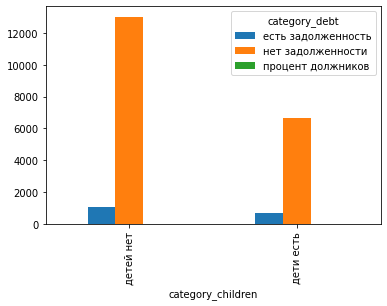

In [16]:
df_pivot_children.plot.bar()

**Вывод** 

Пары которые имеют детей отдают кредиты хуже, чем пары у которых детей нет.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [17]:
df_pivot_family = df.pivot_table(index=['family_status'], columns='category_debt', values='debt', aggfunc='count')#создадим сводную таблицу
df_pivot_family['процент должников'] = (df_pivot_family['есть задолженность'] / (df_pivot_family['нет задолженности']+df_pivot_family['есть задолженность']) * 100)#добавим столбец со значениями процента должников
df_pivot_family = df_pivot_family.round(2)#округляем значения до 2 цифр после точки
display(df_pivot_family.sort_values('процент должников', axis=0, ascending=False))#выведем на экран данные таблицы

category_debt,есть задолженность,нет задолженности,процент должников
family_status,,,
Не женат / не замужем,274,2536,9.75
гражданский брак,388,3763,9.35
женат / замужем,931,11408,7.55
в разводе,85,1110,7.11
вдовец / вдова,63,896,6.57


<AxesSubplot:xlabel='family_status'>

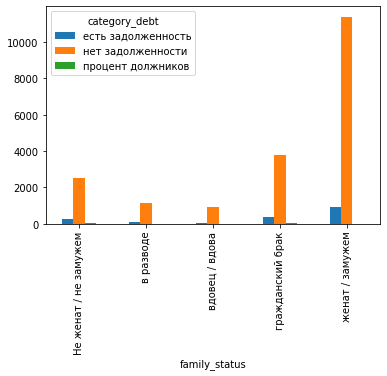

In [18]:
df_pivot_family.plot.bar()

**Вывод** 

Судя по полученным данным хуже всех отдают кредиты холостые, за ними идут пары состоящие в гражданском браке, далее идут пары состоящие в официальном браке. Меньше всех задолженности имеют овдовевшие, и люди в разводе.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [19]:
df_pivot_income = df.pivot_table(index=['category_income'], columns='category_debt', values='debt', aggfunc='count')#создадим сводную таблицу
df_pivot_income['процент должников'] = (df_pivot_income['есть задолженность'] / (df_pivot_income['нет задолженности']+df_pivot_income['есть задолженность']) * 100)#добавим столбец со значениями процента должников
df_pivot_income = df_pivot_income.round(2)#округляем значения до 2 цифр после точки
display(df_pivot_income.sort_values('процент должников', axis=0, ascending=False))#выведем на экран данные таблицы

category_debt,есть задолженность,нет задолженности,процент должников
category_income,,,
средний доход,1552,17435,8.17
высокий доход,1,12,7.69
низкий доход,188,2266,7.66


<AxesSubplot:xlabel='category_income'>

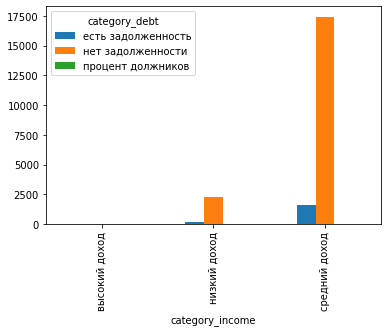

In [20]:
df_pivot_income.plot.bar()

**Вывод**

 Больше всего должников среди людей со среднем уровнем дохода, люди с высоким и низким уровнем имеют примерно одинаковые показатели.

- Как разные цели кредита влияют на его возврат в срок?

In [21]:
df_pivot_purpose = df.pivot_table(index=['purpose_category'], columns='category_debt', values='debt', aggfunc='count')#создадим сводную таблицу
df_pivot_purpose['процент должников'] = (df_pivot_purpose['есть задолженность'] / (df_pivot_purpose['нет задолженности']+df_pivot_purpose['есть задолженность']) * 100)#добавим столбец со значениями процента должников
df_pivot_purpose = df_pivot_purpose.round(2)#округляем значения до 2 цифр после точки
display(df_pivot_purpose.sort_values('процент должников', axis=0, ascending=False))#выведем на экран данные таблицы

category_debt,есть задолженность,нет задолженности,процент должников
purpose_category,,,
автомобиль,403,3903,9.36
образование,370,3643,9.22
свадьба,186,2138,8.00
недвижимость,782,10029,7.23


<AxesSubplot:xlabel='purpose_category'>

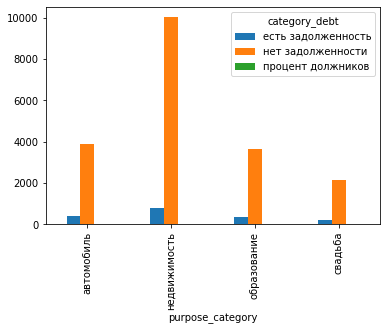

In [22]:
df_pivot_purpose.plot.bar()

**Вывод** 

Кредиты взятые на недвижимость имеют меньше всего просроченных задолженностей, на втором месте кредиты взятые на свадьбу, на третьем на образование, ну и хуже всего отдают кредиты взятые на автомобиль.

## Шаг 4. Общий вывод

По итогам проделанной работы можно сделать вывод, что в таблице встречается довольно много пропущенных значений и ошибок, которые мы в ходе работы постарались исправить.
Пары которые имеют детей отдают кредиты хуже, чем пары у которых детей нет, так же судя по полученным данным хуже всех отдают кредиты холостые, за ними идут пары состоящие в гражданском браке, далее идут пары состоящие в официальном браке. Меньше всех задолженности имеют овдовевшие, и люди в разводе.
Много должников среди людей со среднем уровнем дохода, люди с высоким и низким уровнем имеют примерно одинаковые показатели. Кредиты взятые на недвижимость имеют меньше всего просроченных задолженностей, на втором месте кредиты взятые на свадьбу, на третьем на образование, ну и хуже всего отдают кредиты взятые на автомобиль.